# Water Potability

## Importing libraries

In [1]:
import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from scipy.stats import randint
from sklearn.metrics import roc_curve, auc, classification_report, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import joblib

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("water_potability.csv")

df.shape

(3276, 10)

## EDA

In [3]:
df.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


The df is made of 9 features, the target is **'Potability'**: *1* means potable and *0* non potable. 
<br> Some features have null values. Later we are gonna take care of them. 

In [5]:
df.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

<br>

Let's look for some correlations:

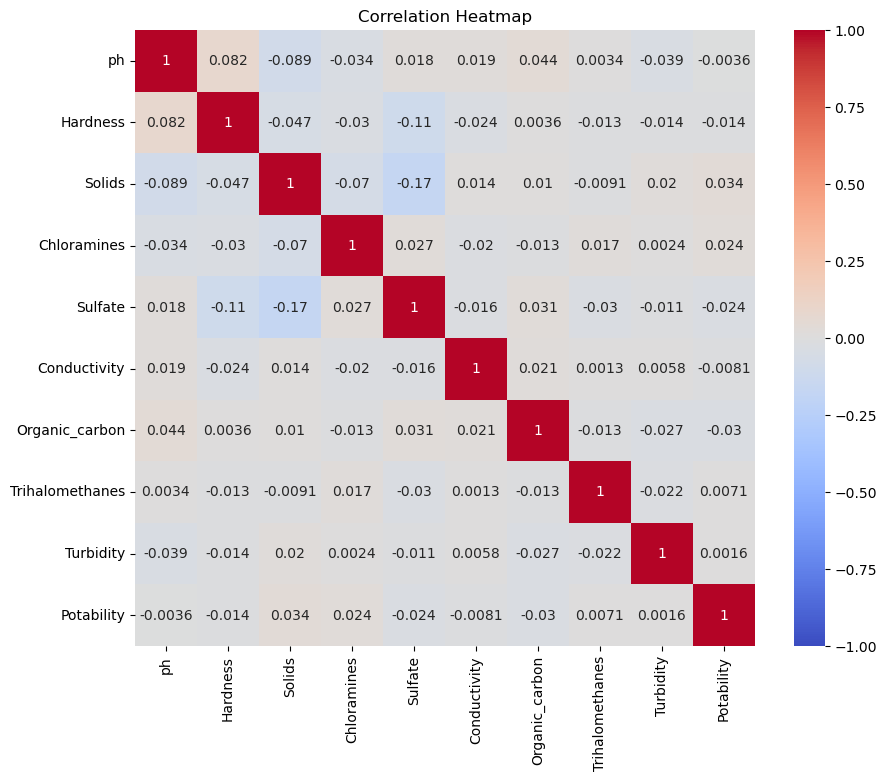

In [6]:
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

None of the seems to be features is highly correlated. <br>
<br>
Let's see if it's possible to distinguish betweet potable and non potable water from the distributions:

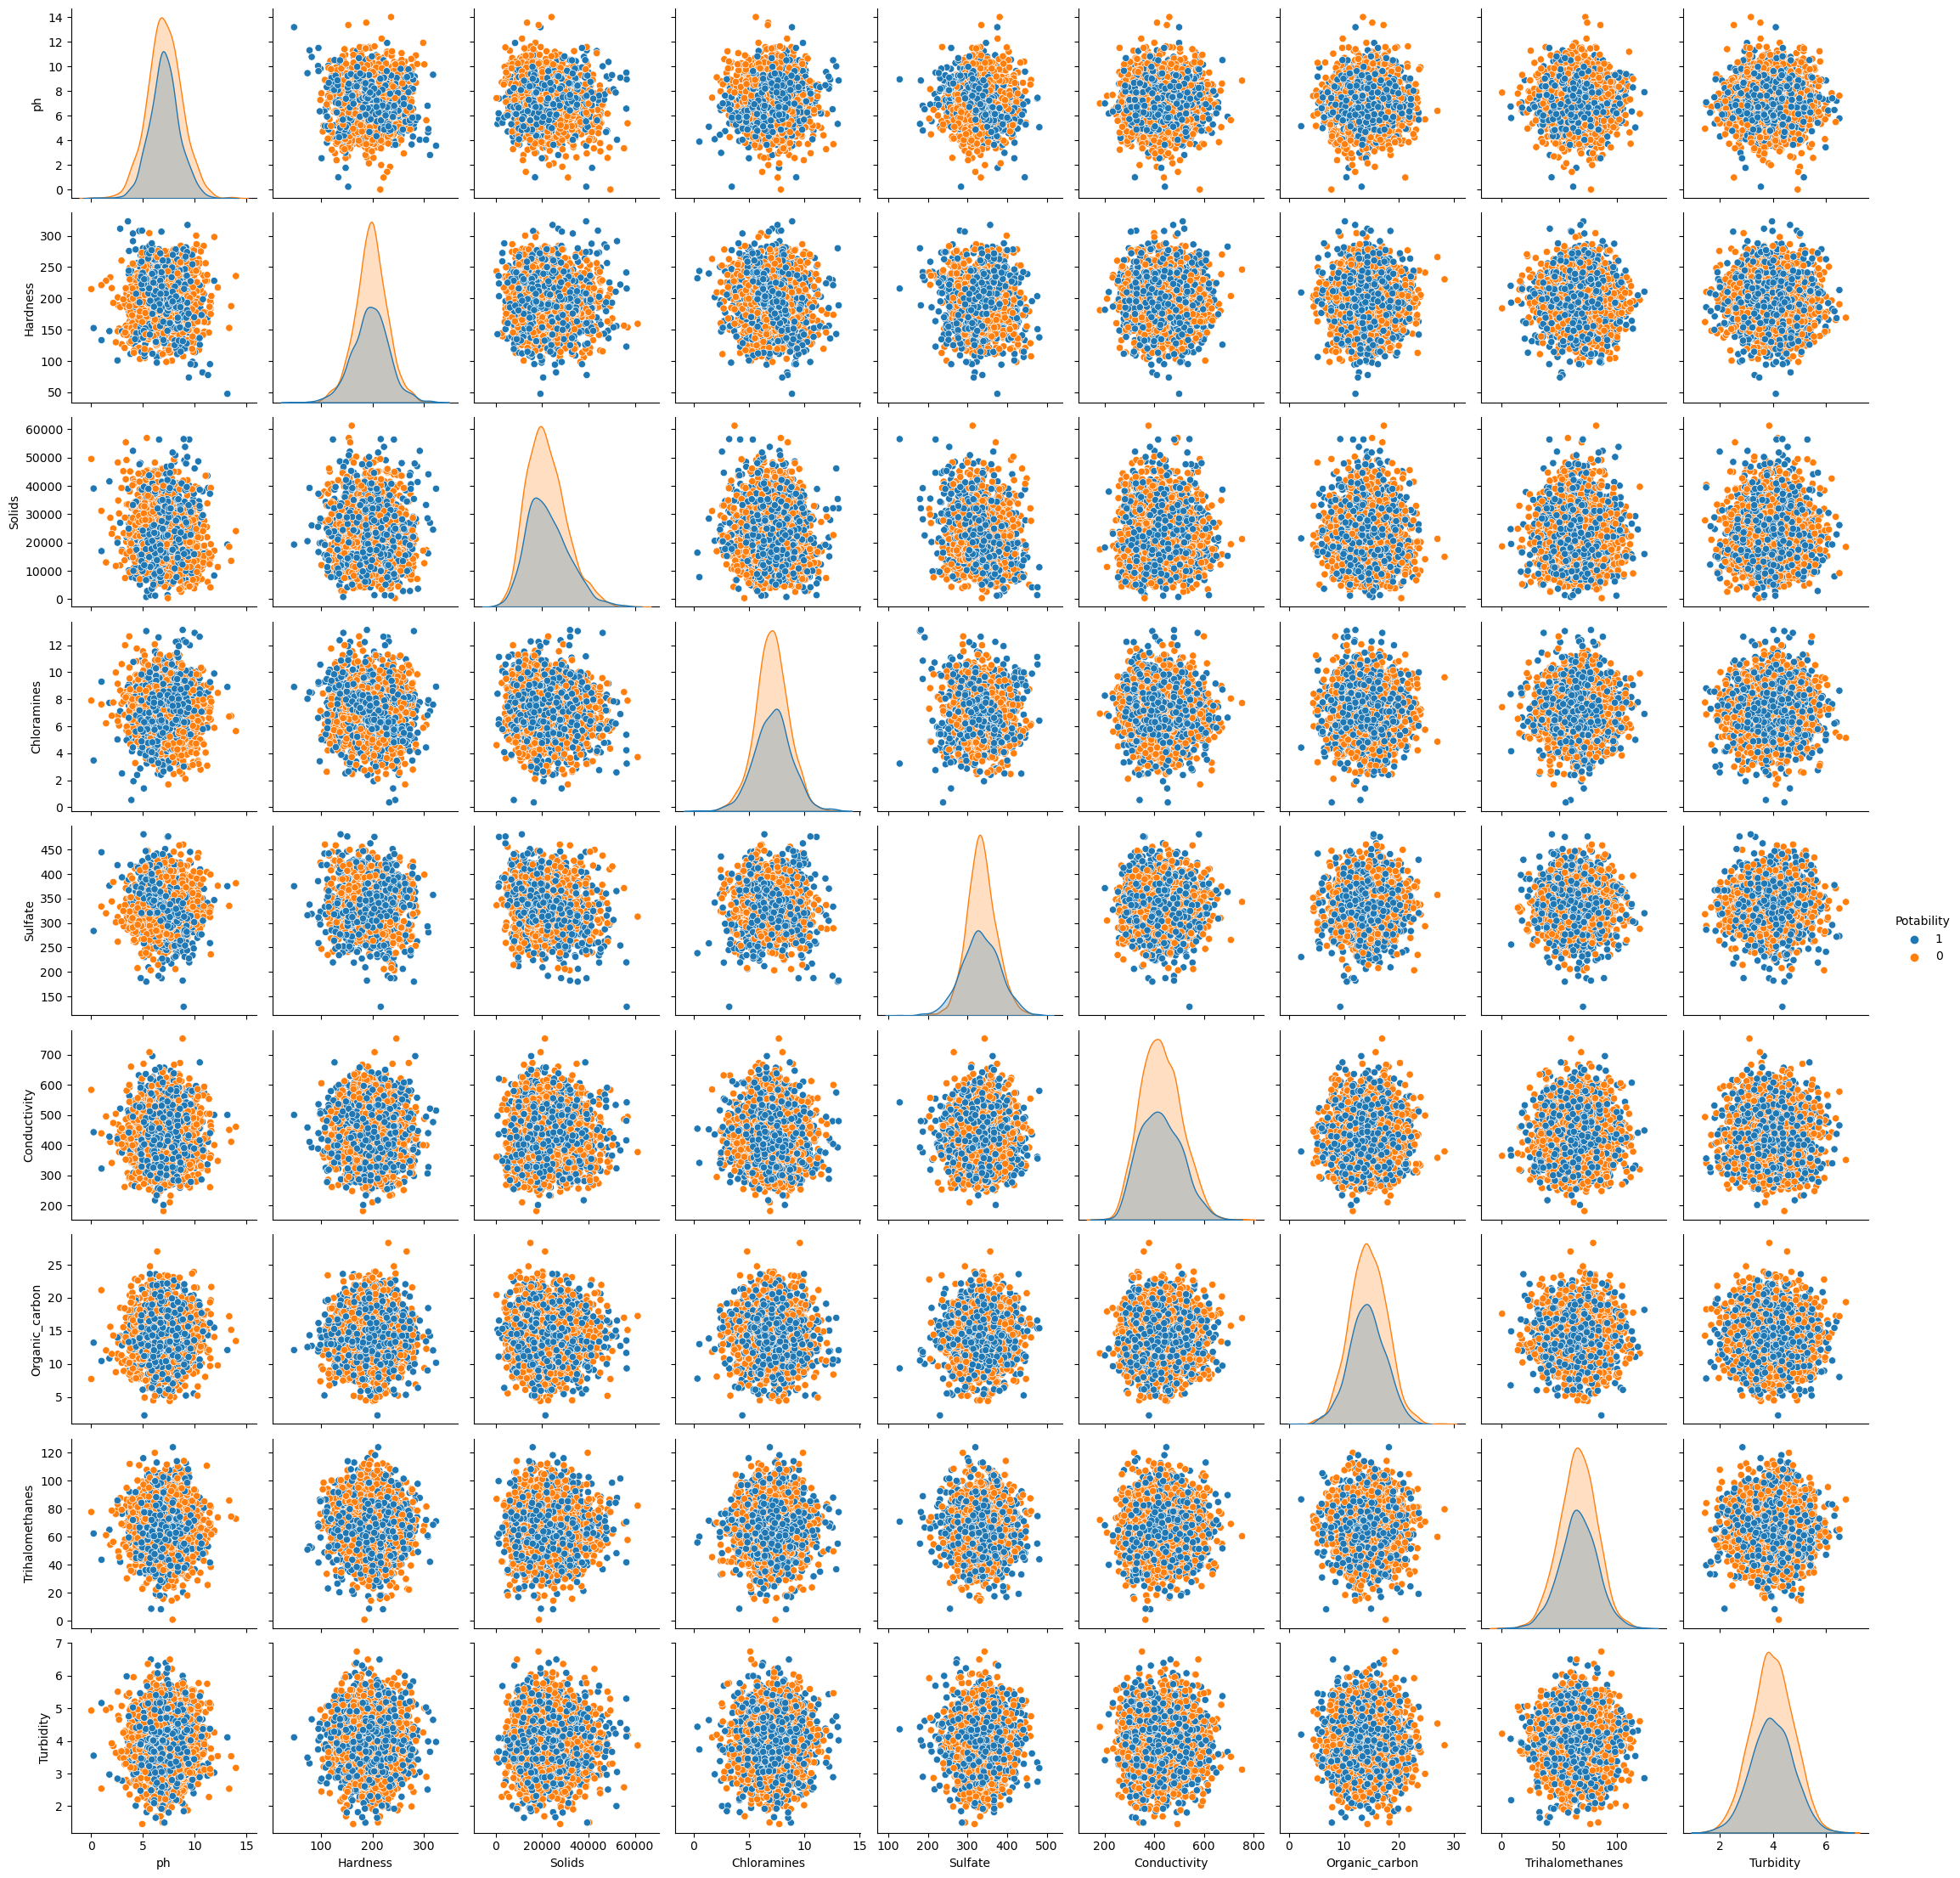

In [7]:
sns.pairplot(df, hue="Potability", hue_order=[1, 0])

There isn't an intuitive relation betweet features. 
<br>
<br>

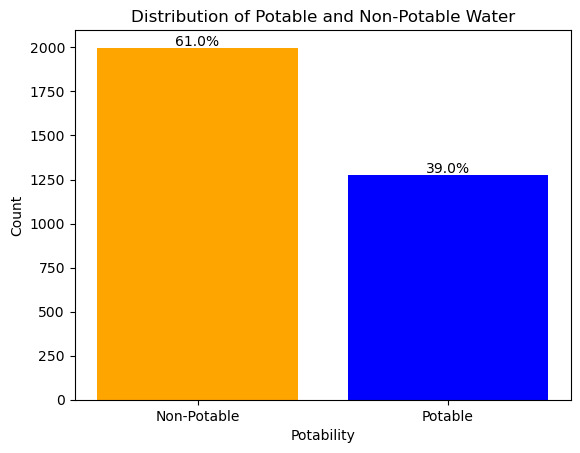

In [8]:
potability_counts = df['Potability'].value_counts()


total_samples = df.shape[0]
potability_percentages = potability_counts / total_samples * 100


colors = ['orange', 'blue']


plt.bar(potability_counts.index, potability_counts.values, color=colors)


plt.xlabel('Potability')
plt.ylabel('Count')
plt.title('Distribution of Potable and Non-Potable Water')


plt.xticks(potability_counts.index, ['Non-Potable', 'Potable'])


for i, count in enumerate(potability_counts):
    plt.text(i, count + 10, f'{potability_percentages[i]:.1f}%', ha='center')


plt.show()

The classes of the target are not balanced. We're going to take it into account.
<br>
<br>

How to manage NaN values? Let's have a look to features' distribution and their **means** related to potable and non potable water.

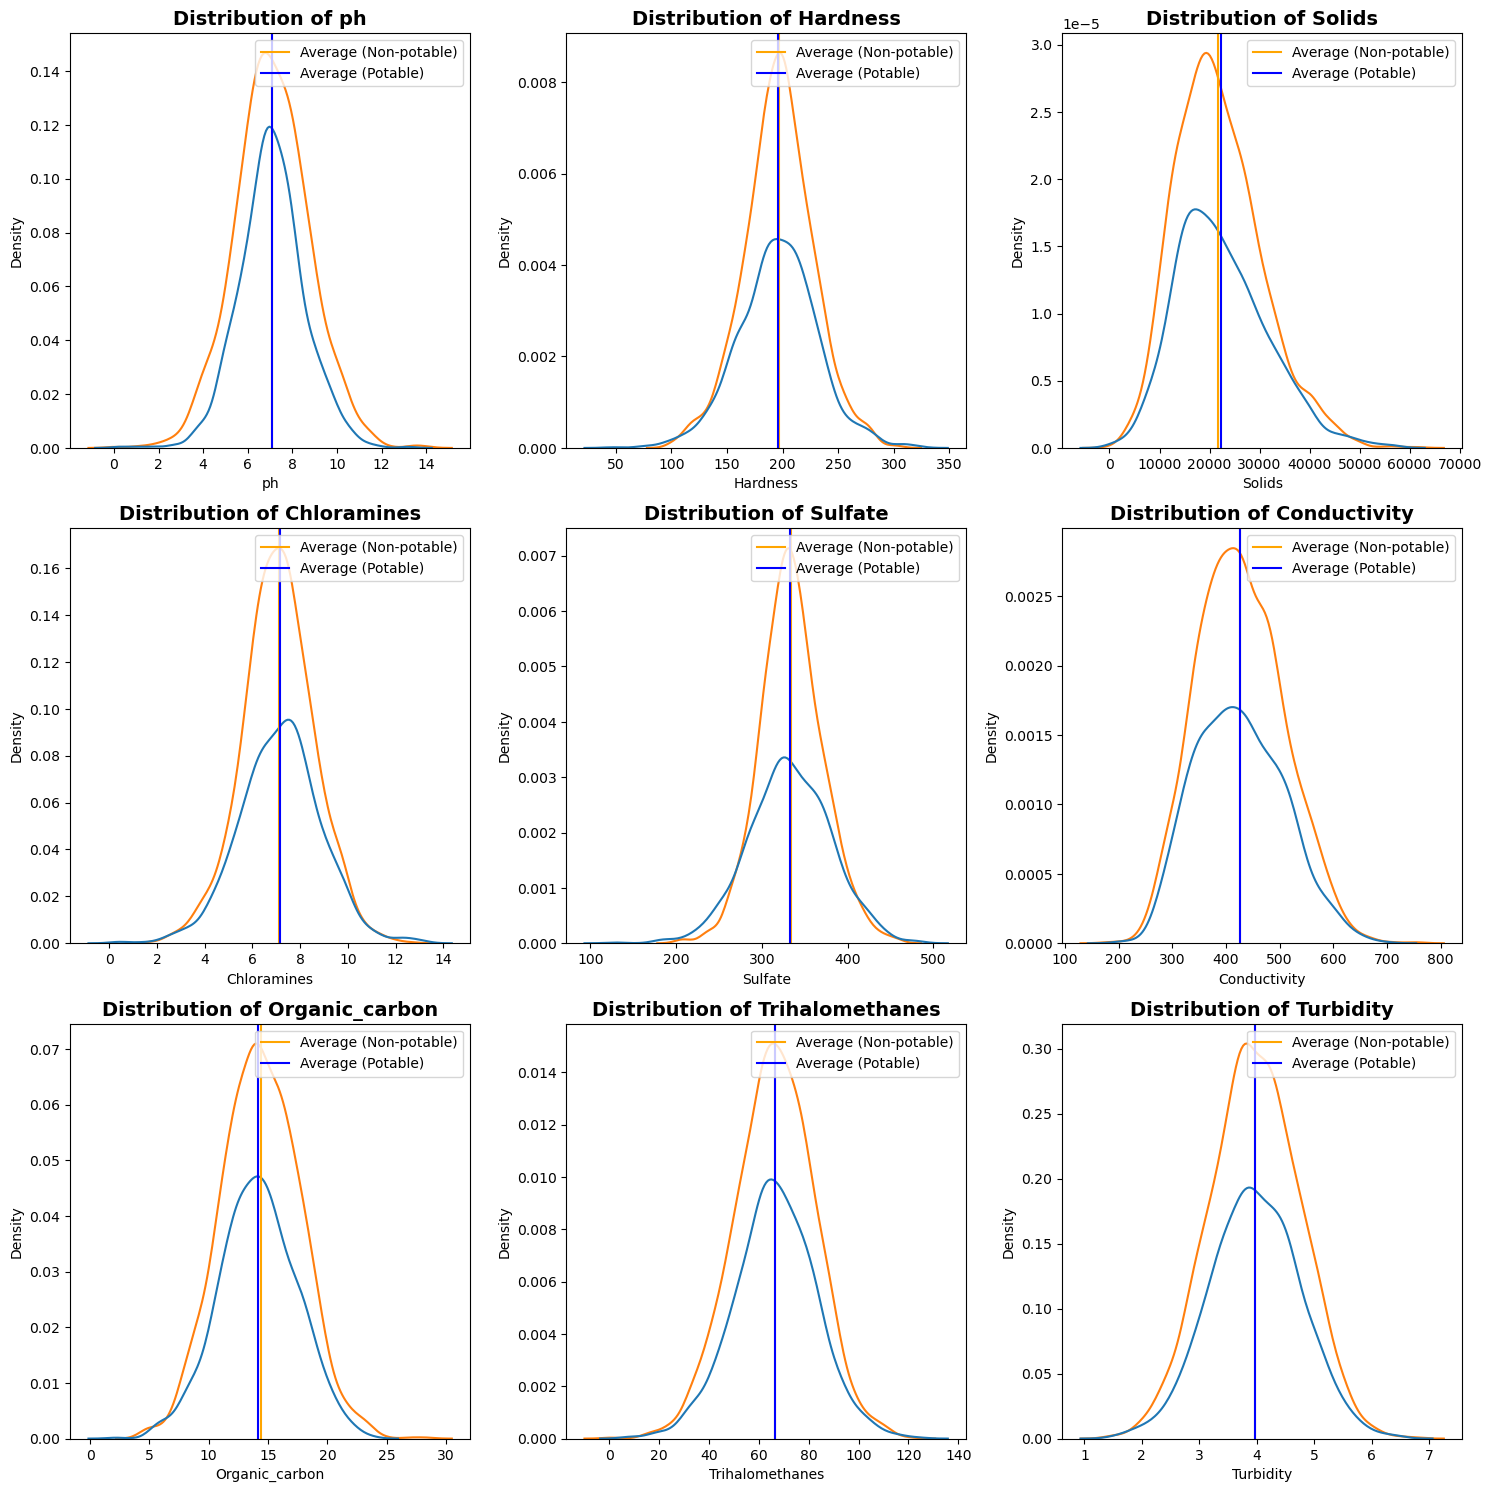

In [9]:
# Calculate the number of rows and columns for subplots
num_features = len(df.columns) - 1  # Exclude the target ('Potability')
num_rows = (num_features + 2) // 3  # Adjust the number of rows based on the number of features

# Create subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

# Flatten the axes array
axes = axes.flatten()

# Iterate over each feature
for i, feature in enumerate(df.columns[:-1]): 
    ax = axes[i]
    sns.kdeplot(data=df, x=feature, hue='Potability', hue_order=[1, 0], ax=ax)
    avg_potable = df[df['Potability'] == 1][feature].mean()
    avg_non_potable = df[df['Potability'] == 0][feature].mean()
    ax.axvline(avg_non_potable, color='orange', linestyle='-', label='Average (Non-potable)', linewidth=1.5)
    ax.axvline(avg_potable, color='blue', linestyle='-', label='Average (Potable)', linewidth=1.5)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title('Distribution of {}'.format(feature), fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=10)

# Adjust spacing between subplots
plt.tight_layout(pad=1.0)

plt.show()



The means of the distributions of potable and non potable water is almost identical for all features.
<br>
<br>

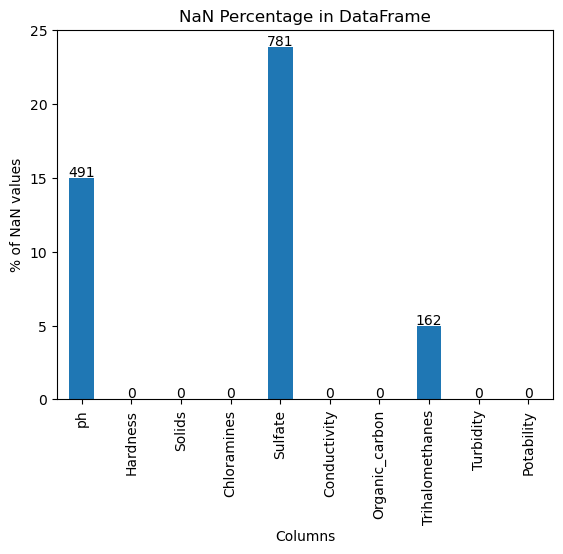

In [10]:
# Calculate the percentage and count of NaN values
nan_percentage = df.isnull().sum() / len(df) * 100
nan_count = df.isnull().sum()

# Plot the NaN percentage with count
fig, ax = plt.subplots()
nan_percentage.plot(kind='bar', ax=ax)
ax.set_xlabel('Columns')
ax.set_ylabel('% of NaN values')

# Add the count as text labels
for i, v in enumerate(nan_count):
    ax.text(i, nan_percentage[i]+0.1, str(v), ha='center')

plt.title('NaN Percentage in DataFrame')
plt.show()


Only 3 features have NaNs. Sulfate and pH are are respectively almost 25% and 15%. 

## Data Preprocessing
Before any preprocessing stage I want to avoid any data leakage. So, I split the train and test set.


In [11]:
# Split features and target
y = df['Potability'].values  
X = df.drop('Potability', axis=1).values  


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=42)

# Checking the shape
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2948, 9), (328, 9), (2948,), (328,))

The stratified split needs to maintain the original balance also in the test set.<br>
The test size is 0.1 to leave an appropriate quantity of information to training set.

Now, I am building a simple preprocessing pipeline. I have chosen to replace NaN values with the mean value because there isn't a significant difference between the distribution of each feature in the two classes. I have chosen standard scaler to give unififormity to the distributions.

In [12]:
# Create a pipeline with two steps: imputation and standard scaling
preprocessing_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Replace NaN with the mean
    ('scaler', StandardScaler())  # Apply standard scaling
])

# Fit and transform the pipeline on X_train
X_train_preprocessed = preprocessing_pipeline.fit_transform(X_train)

# Transform X_test using the fitted pipeline
X_test_preprocessed = preprocessing_pipeline.transform(X_test)


In [13]:
nan_indices = np.isnan(X_train_preprocessed)
if np.any(nan_indices):
    print("NaN values found in X_train!")
else:
    print("No NaN values in X_train.")

nan_indices = np.isnan(X_test_preprocessed)
if np.any(nan_indices):
    print("NaN values found in X_test!")
else:
    print("No NaN values in X_test.")

No NaN values in X_train.
No NaN values in X_test.


### A baseline model

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.80      0.72       200
           1       0.52      0.34      0.42       128

    accuracy                           0.62       328
   macro avg       0.59      0.57      0.57       328
weighted avg       0.60      0.62      0.60       328

---------------------------------------------------


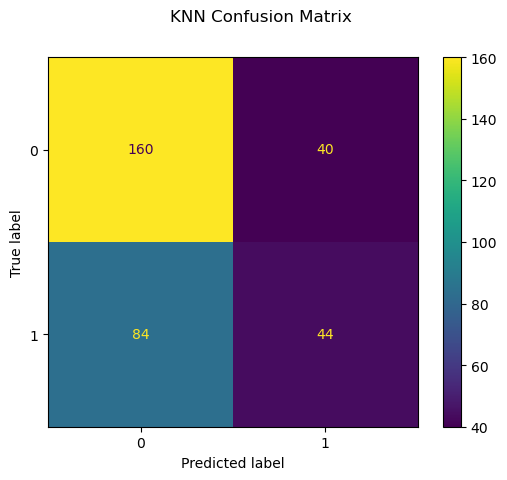

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.61      1.00      0.76       200
           1       1.00      0.01      0.02       128

    accuracy                           0.61       328
   macro avg       0.81      0.50      0.39       328
weighted avg       0.76      0.61      0.47       328

---------------------------------------------------


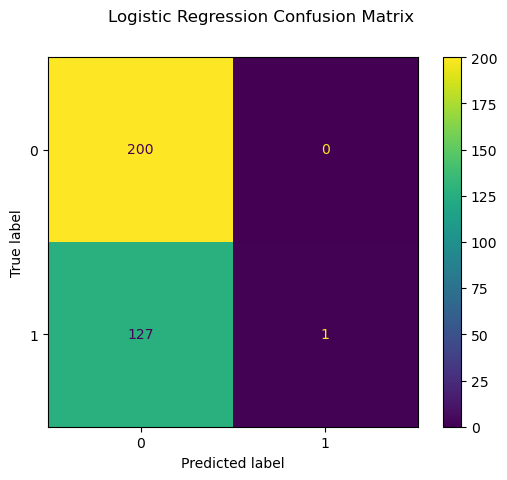

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.70      0.69       200
           1       0.50      0.47      0.49       128

    accuracy                           0.61       328
   macro avg       0.59      0.59      0.59       328
weighted avg       0.61      0.61      0.61       328

---------------------------------------------------


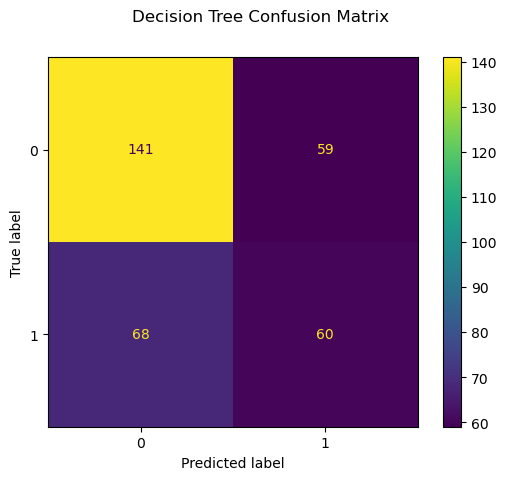

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.93      0.79       200
           1       0.74      0.34      0.46       128

    accuracy                           0.70       328
   macro avg       0.71      0.63      0.62       328
weighted avg       0.71      0.70      0.66       328

---------------------------------------------------


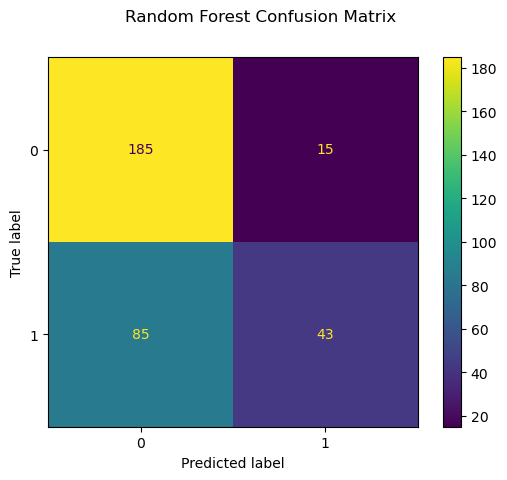

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.84      0.76       200
           1       0.61      0.40      0.48       128

    accuracy                           0.67       328
   macro avg       0.65      0.62      0.62       328
weighted avg       0.66      0.67      0.65       328

---------------------------------------------------


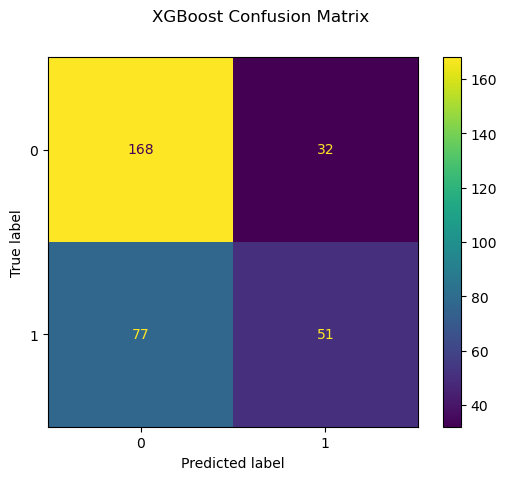

In [14]:
# Define the models to evaluate
models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

# Create an empty DataFrame to store the results
results_df_baseline = pd.DataFrame(columns=["Model", "Class", "Precision", "Recall", "F1"])

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_train_preprocessed, y_train)
    y_pred = model.predict(X_test_preprocessed)
    
    # Calculate precision, recall, and F1 score for class 0
    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    
    # Calculate precision, recall, and F1 score for class 1
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Append the results to the DataFrame
    results_df_baseline = results_df_baseline.append({
        "Model": model_name,
        "Class": 0,
        "Precision": precision_0,
        "Recall": recall_0,
        "F1": f1_0
    }, ignore_index=True)
    
    results_df_baseline = results_df_baseline.append({
        "Model": model_name,
        "Class": 1,
        "Precision": precision_1,
        "Recall": recall_1,
        "F1": f1_1
    }, ignore_index=True)
    
    report = classification_report(y_test, y_pred)
    
    # Print the model name and classification report
    print(f"{model_name} Classification Report:")
    print(report)
    print("---------------------------------------------------")
    
    # Plot confusion matrix
    disp = plot_confusion_matrix(model, X_test_preprocessed, y_test)
    disp.figure_.suptitle(f"{model_name} Confusion Matrix")
    plt.show()
    



It's clear that the performance are not the best with this models. Before any furher analysis I try to balance the classes.



In [15]:
results_df_baseline

Model Class  Precision    Recall        F1
0                  KNN     0   0.655738  0.800000  0.720721
1                  KNN     1   0.523810  0.343750  0.415094
2  Logistic Regression     0   0.611621  1.000000  0.759013
3  Logistic Regression     1   1.000000  0.007812  0.015504
4        Decision Tree     0   0.674641  0.705000  0.689487
5        Decision Tree     1   0.504202  0.468750  0.485830
6        Random Forest     0   0.685185  0.925000  0.787234
7        Random Forest     1   0.741379  0.335938  0.462366
8              XGBoost     0   0.685714  0.840000  0.755056
9              XGBoost     1   0.614458  0.398438  0.483412

### Balancing the classes
In order to take care of the class unbalance I'm going to use an oversampling technique using the *SMOTE* algorithm. I'm going to apply it *only* in the training set in order to avoid data leakage.

In [16]:
oversampling_pipeline = Pipeline([
    ('oversampler', SMOTE(random_state=42))
])

# Fit and resample the training set using the oversampling pipeline
X_train_oversampled, y_train_oversampled = oversampling_pipeline.fit_resample(X_train_preprocessed, y_train)

KNN Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.62      0.65       200
           1       0.48      0.53      0.50       128

    accuracy                           0.59       328
   macro avg       0.58      0.58      0.58       328
weighted avg       0.60      0.59      0.59       328

---------------------------------------------------


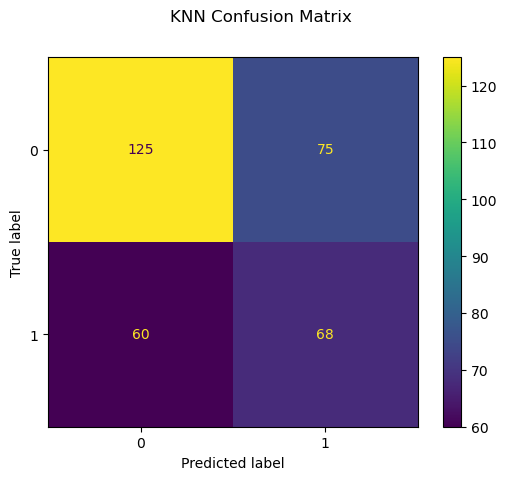

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.47      0.53       200
           1       0.38      0.51      0.44       128

    accuracy                           0.49       328
   macro avg       0.49      0.49      0.48       328
weighted avg       0.52      0.49      0.49       328

---------------------------------------------------


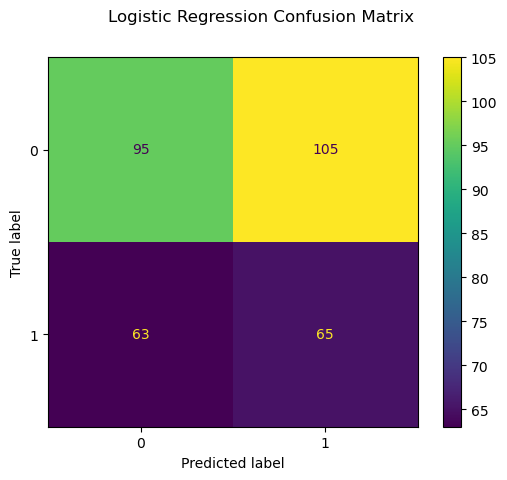

Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.62      0.64       200
           1       0.45      0.48      0.47       128

    accuracy                           0.57       328
   macro avg       0.55      0.55      0.55       328
weighted avg       0.58      0.57      0.57       328

---------------------------------------------------


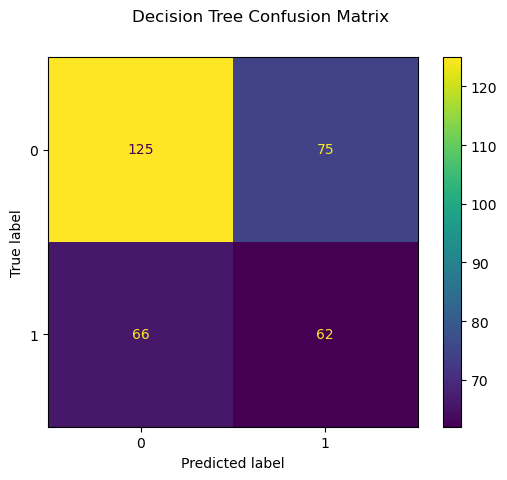

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.81      0.75       200
           1       0.60      0.44      0.50       128

    accuracy                           0.66       328
   macro avg       0.64      0.62      0.63       328
weighted avg       0.65      0.66      0.65       328

---------------------------------------------------


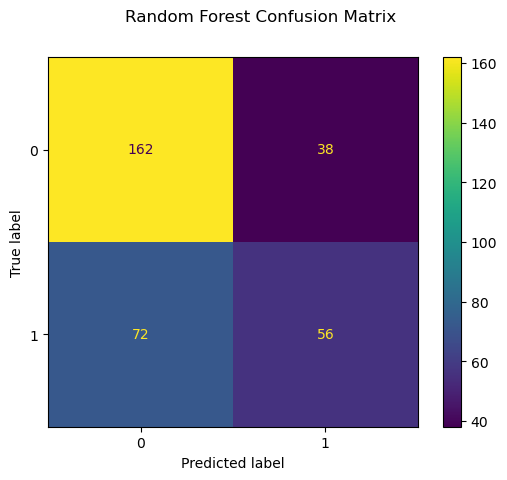

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.76      0.72       200
           1       0.56      0.47      0.51       128

    accuracy                           0.65       328
   macro avg       0.62      0.61      0.62       328
weighted avg       0.64      0.65      0.64       328

---------------------------------------------------


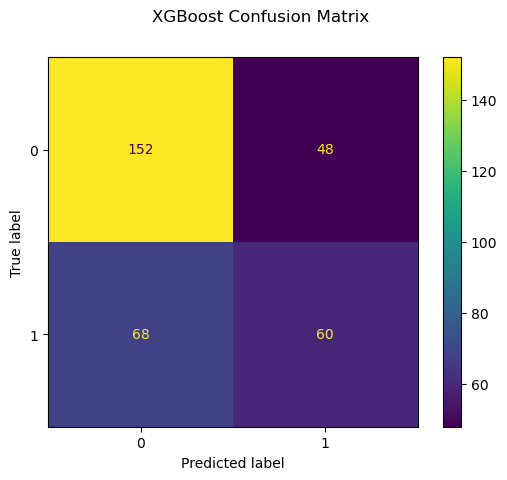

In [17]:
models = {
    "KNN": KNeighborsClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier()
}

# Create an empty DataFrame to store the results
results_df_balanced = pd.DataFrame(columns=["Model", "Class", "Precision", "Recall", "F1"])

# Evaluate each model
for model_name, model in models.items():
    model.fit(X_train_oversampled, y_train_oversampled)
    y_pred = model.predict(X_test_preprocessed)
    
    # Calculate precision, recall, and F1 score for class 0
    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)
    
    # Calculate precision, recall, and F1 score for class 1
    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)
    
    # Append the results to the DataFrame
    results_df_balanced = results_df_balanced.append({
        "Model": model_name,
        "Class": 0,
        "Precision": precision_0,
        "Recall": recall_0,
        "F1": f1_0
    }, ignore_index=True)
    
    results_df_balanced = results_df_balanced.append({
        "Model": model_name,
        "Class": 1,
        "Precision": precision_1,
        "Recall": recall_1,
        "F1": f1_1
    }, ignore_index=True)
    
    report = classification_report(y_test, y_pred)
    
    # Print the model name and classification report
    print(f"{model_name} Classification Report:")
    print(report)
    print("---------------------------------------------------")
    
    # Plot confusion matrix
    disp = plot_confusion_matrix(model, X_test_preprocessed, y_test)
    disp.figure_.suptitle(f"{model_name} Confusion Matrix")
    plt.show()



With a balanced training set, the improvements are not significant. The more promising models are Random Forest and XGBoost. In a real-world application, I believe that the recall of non-potable water should be a critical aspect. In fact, a high score in this parameter should reduce the possibility of consuming non-potable water.

In [18]:
results_df_balanced

Model Class  Precision    Recall        F1
0                  KNN     0   0.675676  0.625000  0.649351
1                  KNN     1   0.475524  0.531250  0.501845
2  Logistic Regression     0   0.601266  0.475000  0.530726
3  Logistic Regression     1   0.382353  0.507812  0.436242
4        Decision Tree     0   0.654450  0.625000  0.639386
5        Decision Tree     1   0.452555  0.484375  0.467925
6        Random Forest     0   0.692308  0.810000  0.746544
7        Random Forest     1   0.595745  0.437500  0.504505
8              XGBoost     0   0.690909  0.760000  0.723810
9              XGBoost     1   0.555556  0.468750  0.508475

In [19]:
results_df_balanced[results_df_balanced['Class']==0].sort_values('Recall', ascending=False)

Model Class  Precision  Recall        F1
6        Random Forest     0   0.692308   0.810  0.746544
8              XGBoost     0   0.690909   0.760  0.723810
0                  KNN     0   0.675676   0.625  0.649351
4        Decision Tree     0   0.654450   0.625  0.639386
2  Logistic Regression     0   0.601266   0.475  0.530726

RF has the highest recall of non-potable water for now.

### Hyperparameter tuning
I try to optimize Random Forest and XGboost because in general performed better and they have more parameters. <br>
**Random Forest:**

In [98]:
#Let's start with general parameters

param_grid = {
    'n_estimators': [50, 100, 200, 500],      # Number of trees
    'max_depth': [None, 5, 10, 20],            # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required at each leaf node
    'max_features': ['auto', 'sqrt', 'log2']   # Number of features to consider at each split
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                           # Number of cross-validation folds
    n_jobs=-1,                      # Utilize all available CPU cores
    scoring='f1_macro'              # Scoring metric: F1 score with macro averaging
)

# Perform grid search for hyperparameter tuning
grid_search.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Retrieve the best trained model
best_rf_model = grid_search.best_estimator_

# Save the model to a file
joblib.dump(best_rf_model, 'random_forest_model_1.pkl')

Best Hyperparameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


['random_forest_model_1.pkl']

In [20]:
# Loading the model

best_rf_model1 = joblib.load('random_forest_model_1.pkl')

In [21]:
# Predict on the test set using the best model
y_pred = best_rf_model1.predict(X_test_preprocessed)

# Calculate the F1 score for each class
f1_class0 = f1_score(y_test, y_pred, pos_label=0)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

print("F1 Score - Class 0:", f1_class0)
print("F1 Score - Class 1:", f1_class1)


F1 Score - Class 0: 0.7720090293453725
F1 Score - Class 1: 0.5258215962441315


In [22]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       200
           1       0.66      0.44      0.53       128

    accuracy                           0.69       328
   macro avg       0.68      0.65      0.65       328
weighted avg       0.69      0.69      0.68       328



Let's evaluate our model also on the train test:

In [24]:
y_pred_train = best_rf_model1.predict(X_train_oversampled)

report = classification_report(y_train_oversampled, y_pred_train)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1798
           1       1.00      1.00      1.00      1798

    accuracy                           1.00      3596
   macro avg       1.00      1.00      1.00      3596
weighted avg       1.00      1.00      1.00      3596



It's **overfitting** so badly! This means that this model is unable to generalize on unseen data.
I try to reduce the number of parameters:

In [105]:
# Define a reduced parameter grid
param_grid = {
    'n_estimators': [10, 20, 30],         # Number of trees
    'max_depth': [2, 3, 4],                # Maximum depth of each tree
    'min_samples_split': [2, 4, 6],        # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 3, 5],         # Minimum number of samples required at each leaf node
    'max_features': ['sqrt', 'log2']       # Number of features to consider at each split
}

# Create a Random Forest classifier
rf = RandomForestClassifier()

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,                           # Number of cross-validation folds
    n_jobs=-1,
    scoring='f1_macro'              # Scoring metric: F1 score with macro averaging
)

# Perform grid search for hyperparameter tuning
grid_search.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Retrieve the best trained model
best_rf_model = grid_search.best_estimator_

# Save the model to a file
joblib.dump(best_rf_model, 'random_forest_model_2.pkl')

Best Hyperparameters: {'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 30}


['random_forest_model_2.pkl']

In [25]:
# Loading the model

best_rf_model_2 = joblib.load('random_forest_model_2.pkl')

In [26]:
# Predict on the test set using the best model
y_pred = best_rf_model_2.predict(X_test_preprocessed)

# Calculate the F1 score for each class
f1_class0 = f1_score(y_test, y_pred, pos_label=0)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

print("F1 Score - Class 0:", f1_class0)
print("F1 Score - Class 1:", f1_class1)


F1 Score - Class 0: 0.6938775510204083
F1 Score - Class 1: 0.5454545454545455


              precision    recall  f1-score   support

           0       0.71      0.68      0.69       200
           1       0.53      0.56      0.55       128

    accuracy                           0.63       328
   macro avg       0.62      0.62      0.62       328
weighted avg       0.64      0.63      0.64       328



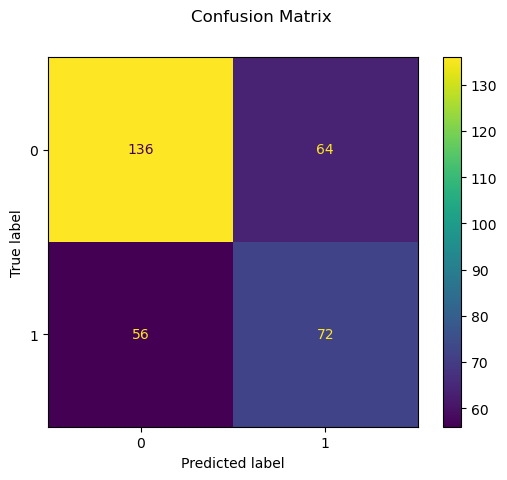

In [27]:
report = classification_report(y_test, y_pred)
print(report)

# Plot confusion matrix
disp = plot_confusion_matrix(best_rf_model_2, X_test_preprocessed, y_test)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [28]:
y_pred_train = best_rf_model_2.predict(X_train_oversampled)

report = classification_report(y_train_oversampled, y_pred_train)
print(report)



              precision    recall  f1-score   support

           0       0.65      0.71      0.68      1798
           1       0.68      0.62      0.65      1798

    accuracy                           0.66      3596
   macro avg       0.67      0.66      0.66      3596
weighted avg       0.67      0.66      0.66      3596



Now the overfitting problem seems to be taimed off. The F1 score of *potable water* is still very low.

### XGboost

In [88]:
# Define the parameter grid
param_grid = {
    'n_estimators': randint(100, 1000),  # Number of trees
    'max_depth': randint(2, 20),         # Maximum depth of each tree
    'learning_rate': [0.001, 0.01, 0.1], # Learning rate
    'subsample': [0.6, 0.8, 1.0],        # Subsample ratio
    'colsample_bytree': [0.6, 0.8, 1.0], # Feature subsampling ratio
    'gamma': [0, 0.1, 0.2],              # Minimum loss reduction for a split
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier()

# Create a RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,        # Number of parameter settings that are sampled
    cv=5,             # Number of cross-validation folds
    scoring='f1_macro',     # Scoring metric: F1 score with macro averaging
    n_jobs=-1,   # Utilize all available CPU cores
    random_state=42
)

# Perform random search for hyperparameter tuning
random_search.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("Best Hyperparameters:", random_search.best_params_)

# Retrieve the best trained model
best_xgb_model = random_search.best_estimator_

# Save the model to a file
joblib.dump(best_rf_model, 'xgb_model_f1.pkl')

Best Hyperparameters: {'colsample_bytree': 1.0, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 16, 'n_estimators': 662, 'subsample': 1.0}


['xgb_model_f1.pkl']

In [29]:
# Loading the model

best_xgb_model = joblib.load('xgb_model_f1.pkl')

In [30]:
# Predict on the test set using the best model
y_pred = best_xgb_model.predict(X_test_preprocessed)

# Calculate the F1 score for each class
f1_class0 = f1_score(y_test, y_pred, pos_label=0)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

print("F1 Score - Class 0:", f1_class0)
print("F1 Score - Class 1:", f1_class1)


F1 Score - Class 0: 0.7528868360277136
F1 Score - Class 1: 0.5201793721973094


In [31]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.81      0.75       200
           1       0.61      0.45      0.52       128

    accuracy                           0.67       328
   macro avg       0.66      0.63      0.64       328
weighted avg       0.66      0.67      0.66       328



In [32]:
y_pred_train = best_xgb_model.predict(X_train_oversampled)

report = classification_report(y_train_oversampled, y_pred_train)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1798
           1       1.00      1.00      1.00      1798

    accuracy                           1.00      3596
   macro avg       1.00      1.00      1.00      3596
weighted avg       1.00      1.00      1.00      3596



Like before, the model is overfitting. Let's reduce the hyperparameter space.

In [151]:

# Define the reduced parameter grid
param_grid = {
    'n_estimators': [10, 20],  # Number of trees
    'max_depth': [2,3],              # Maximum depth of each tree
    'learning_rate': [0.01, 0.1],    # Learning rate
    'subsample': [0.8, 1.0],               # Subsample ratio
    'colsample_bytree': [0.6, 0.8],        # Feature subsampling ratio
    'gamma': [0.1, 0.2]                      # Minimum loss reduction for a split
}

# Create an XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42)

# Create a GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,                  # Number of cross-validation folds
    scoring='f1_macro',    # Scoring metric: F1 score with macro averaging
    n_jobs=-1              # Utilize all available CPU cores
)

# Perform grid search for hyperparameter tuning
grid_search.fit(X_train_oversampled, y_train_oversampled)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Retrieve the best trained model
best_xgb_model = grid_search.best_estimator_

# Save the model to a file
joblib.dump(best_xgb_model, 'xgb_model_2.pkl')


Best Hyperparameters: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 20, 'subsample': 0.8}


['xgb_model_2.pkl']

In [33]:
# Loading the model

best_xgb_model = joblib.load('xgb_model_2.pkl')

In [34]:
# Predict on the test set using the best model
y_pred = best_xgb_model.predict(X_test_preprocessed)

# Calculate the F1 score for each class
f1_class0 = f1_score(y_test, y_pred, pos_label=0)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

print("F1 Score - Class 0:", f1_class0)
print("F1 Score - Class 1:", f1_class1)


F1 Score - Class 0: 0.684863523573201
F1 Score - Class 1: 0.4980237154150197


              precision    recall  f1-score   support

           0       0.68      0.69      0.68       200
           1       0.50      0.49      0.50       128

    accuracy                           0.61       328
   macro avg       0.59      0.59      0.59       328
weighted avg       0.61      0.61      0.61       328



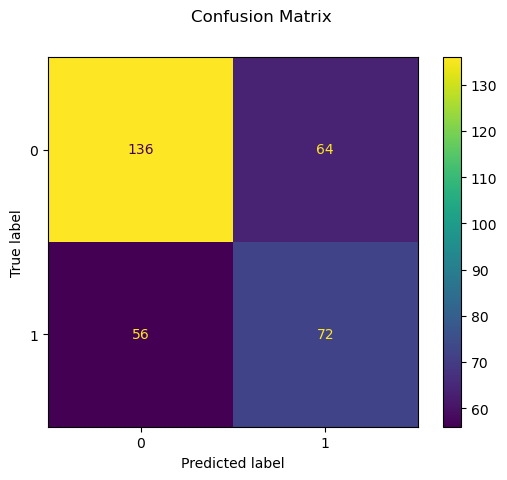

In [35]:
report = classification_report(y_test, y_pred)
print(report)

# Plot confusion matrix
disp = plot_confusion_matrix(best_rf_model_2, X_test_preprocessed, y_test)
disp.figure_.suptitle("Confusion Matrix")
plt.show()

In [36]:
y_pred_train = best_xgb_model.predict(X_train_oversampled)

report = classification_report(y_train_oversampled, y_pred_train)
print(report)

              precision    recall  f1-score   support

           0       0.62      0.73      0.67      1798
           1       0.68      0.56      0.61      1798

    accuracy                           0.65      3596
   macro avg       0.65      0.65      0.64      3596
weighted avg       0.65      0.65      0.64      3596



The XGboost beheavior is more or less similar with Random Forest. To solve the overfitting problem I had to choose a very rescricted hyperparamenter space.

## Conclusions

The performance of this model is unsatisfactory, in real world it can't be used for water quality prediction.
I think this is due to the fact that the distributions of potable and non-potable water are almost overlapping for all the features. But, let me say... it does not have any sense in the real world: the potability of water is regulated **by the law**. 
Though, a real dataset should show a clear distinction between potable and non-potable water. In this way, a simple decision tree should be able to perfectly classify all entries.
<br>

An alterative goal could be to build a model that, with a reduced number of features, is able to discriminate between potable and non-potable water, thus reducing the number of necessary analyses. But, of course, you need a good dataset.